In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv("DailyDelhiClimateTrain.csv")

In [3]:
train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [4]:
train.dtypes

date             object
meantemp        float64
humidity        float64
wind_speed      float64
meanpressure    float64
dtype: object

In [10]:
train['date'] = train['date'].astype('datetime64')

In [11]:
train.dtypes

date            datetime64[ns]
meantemp               float64
humidity               float64
wind_speed             float64
meanpressure           float64
dtype: object

In [13]:
train.set_index("date", inplace= True)

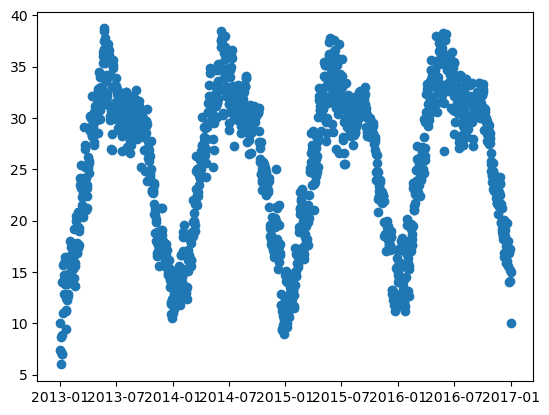

In [17]:
plt.scatter(train.index, train["meantemp"])

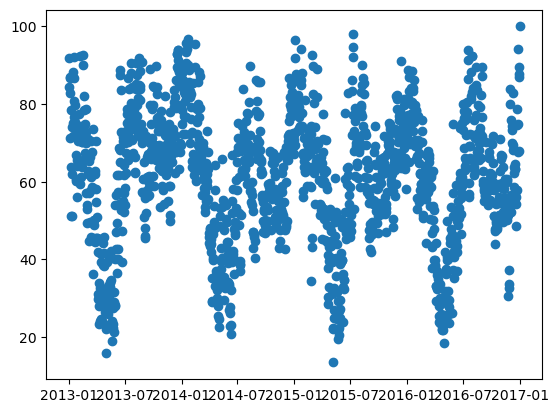

In [19]:
plt.scatter(train.index, train["humidity"])

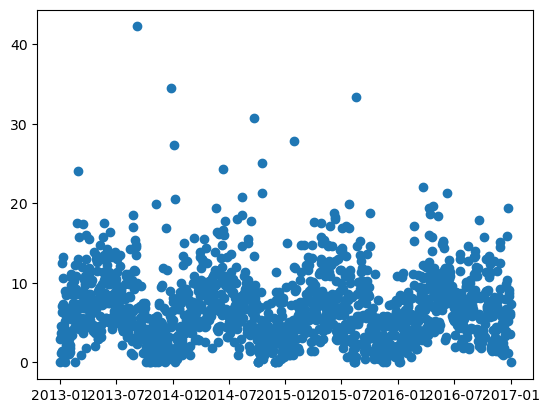

In [20]:
plt.scatter(train.index, train["wind_speed"])

(980.0, 1040.0)

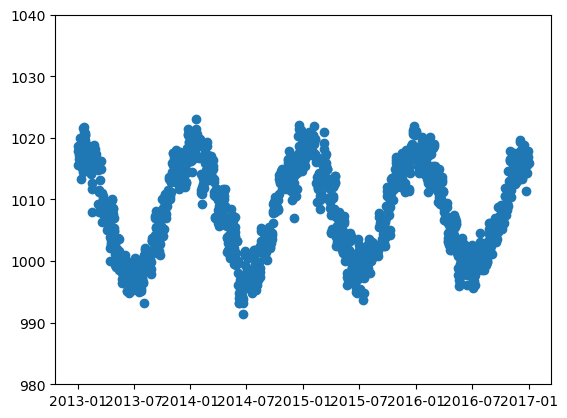

In [25]:
plt.scatter(train.index, train["meanpressure"])
plt.ylim(980,1040)